In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)


In [2]:
WEEKS_PER_YEAR = 52

chains = ["Waterstones", "WHSmith"]

regions_england = [
    "London", "South East", "South West", "East of England",
    "West Midlands", "East Midlands", "Yorkshire and the Humber",
    "North West", "North East"
]

joe_hill_books = [
    {"title": "NOS4A2", "base_popularity": 1.15},
    {"title": "Heart-Shaped Box", "base_popularity": 1.05},
    {"title": "The Fireman", "base_popularity": 1.10},
    {"title": "Horns", "base_popularity": 1.00},
    {"title": "Full Throttle", "base_popularity": 0.90},
    {"title": "20th Century Ghosts", "base_popularity": 0.95},
    {"title": "Strange Weather", "base_popularity": 0.85},
    {"title": "Locke & Key (Vol. 1)", "base_popularity": 1.20},
    {"title": "Locke & Key (Vol. 2)", "base_popularity": 1.05},
]

formats = ["Paperback", "Hardback", "Ebook Voucher", "Audiobook Voucher"]


In [3]:
avg_price = {
    "Paperback": 9.99,
    "Hardback": 18.99,
    "Ebook Voucher": 7.99,
    "Audiobook Voucher": 14.99,
}

# cost ratio = estimated wholesale cost as % of sale price
cost_ratio = {
    "Waterstones": {"Paperback": 0.55, "Hardback": 0.52, "Ebook Voucher": 0.70, "Audiobook Voucher": 0.68},
    "WHSmith":    {"Paperback": 0.58, "Hardback": 0.55, "Ebook Voucher": 0.72, "Audiobook Voucher": 0.70},
}

stores_per_chain = {"Waterstones": 85, "WHSmith": 120}

# discount intensity: more discount -> more units, but lower price
promo_by_chain = {"Waterstones": 0.10, "WHSmith": 0.14}

baseline_units_per_store = {"Waterstones": 8.5, "WHSmith": 6.2}


In [4]:
age_bands = ["16-24", "25-34", "35-44", "45-54", "55+"]
income_bands = ["Low", "Mid", "High"]
gender_bands = ["Woman", "Man", "Non-binary/Other"]

demo_by_chain = {
    "Waterstones": {
        "age": np.array([0.18, 0.28, 0.22, 0.17, 0.15]),
        "income": np.array([0.20, 0.55, 0.25]),
        "gender": np.array([0.52, 0.45, 0.03]),
        "customer_type": {"Leisure": 0.62, "Collector": 0.13, "Gift": 0.15, "Commuter": 0.10}
    },
    "WHSmith": {
        "age": np.array([0.12, 0.24, 0.25, 0.20, 0.19]),
        "income": np.array([0.24, 0.60, 0.16]),
        "gender": np.array([0.49, 0.48, 0.03]),
        "customer_type": {"Leisure": 0.40, "Collector": 0.07, "Gift": 0.18, "Commuter": 0.35}
    }
}


In [5]:
region_demand_mult = {
    "London": 1.25, "South East": 1.15, "South West": 0.95, "East of England": 1.00,
    "West Midlands": 1.00, "East Midlands": 0.92, "Yorkshire and the Humber": 0.95,
    "North West": 1.02, "North East": 0.88
}

format_pref = {
    "Waterstones": np.array([0.62, 0.22, 0.08, 0.08]),
    "WHSmith":    np.array([0.50, 0.16, 0.16, 0.18]),
}


In [6]:
def make_stores(chain: str, n: int) -> pd.DataFrame:
    # Weighted toward London + South East
    region_probs = np.array([0.22, 0.16, 0.10, 0.10, 0.12, 0.09, 0.08, 0.09, 0.04])
    region_probs = region_probs / region_probs.sum()

    store_ids = [f"{chain[:2].upper()}-{i:03d}" for i in range(1, n + 1)]
    regions = rng.choice(regions_england, size=n, p=region_probs)

    # Footfall index: WHSmith higher variance (travel hubs), Waterstones more stable
    if chain == "WHSmith":
        footfall = rng.lognormal(mean=0.10, sigma=0.35, size=n)
    else:
        footfall = rng.lognormal(mean=0.05, sigma=0.25, size=n)

    footfall = footfall / np.median(footfall)

    return pd.DataFrame({
        "chain": chain,
        "store_id": store_ids,
        "region": regions,
        "footfall_index": footfall
    })

stores = pd.concat(
    [make_stores(c, stores_per_chain[c]) for c in chains],
    ignore_index=True
)

stores.head()


,chain,store_id,region,footfall_index
0,Waterstones,WA-001,East Midlands,0.956882
1,Waterstones,WA-002,South West,0.780672
2,Waterstones,WA-003,Yorkshire and the Humber,1.188988
3,Waterstones,WA-004,West Midlands,0.936139
4,Waterstones,WA-005,London,1.055994


In [7]:
weeks = pd.date_range("2025-01-06", periods=WEEKS_PER_YEAR, freq="W-MON")
weeks[:5]


DatetimeIndex(['2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27',
               '2025-02-03'],
              dtype='datetime64[ns]', freq='W-MON')

In [8]:
books_df = pd.DataFrame(joe_hill_books)
books_df["book_id"] = np.arange(1, len(books_df) + 1)
books_df


,title,base_popularity,book_id
0,NOS4A2,1.15,1
1,Heart-Shaped Box,1.05,2
2,The Fireman,1.10,3
3,Horns,1.00,4
4,Full Throttle,0.90,5
5,20th Century Ghosts,0.95,6
6,Strange Weather,0.85,7
7,Locke & Key (Vol. 1),1.20,8
8,Locke & Key (Vol. 2),1.05,9


In [9]:
def pick_demographics(chain: str, n: int):
    d = demo_by_chain[chain]
    ages = rng.choice(age_bands, size=n, p=d["age"])
    incomes = rng.choice(income_bands, size=n, p=d["income"])
    genders = rng.choice(gender_bands, size=n, p=d["gender"])

    c_types = list(d["customer_type"].keys())
    c_probs = np.array(list(d["customer_type"].values()))
    c_probs = c_probs / c_probs.sum()
    cust_types = rng.choice(c_types, size=n, p=c_probs)

    return ages, incomes, genders, cust_types


In [10]:
def simulate_week_store_sales(store_row, week_dt):
    chain = store_row["chain"]
    region = store_row["region"]
    footfall = store_row["footfall_index"]

    # Baseline demand: store * region * footfall
    base = baseline_units_per_store[chain] * region_demand_mult[region] * footfall

    # Seasonality: gentle sine wave
    week_of_year = int(week_dt.isocalendar().week)
    seasonal = 1.0 + 0.10 * np.sin(2 * np.pi * (week_of_year / 52))

    # Random shock
    shock = rng.normal(1.0, 0.15)

    # Units sold for that store-week
    store_week_units = max(0, rng.poisson(lam=base * seasonal * shock))
    if store_week_units == 0:
        return []

    # Allocate units across titles by popularity
    popularity = books_df["base_popularity"].to_numpy()
    title_probs = popularity / popularity.sum()
    title_choices = rng.choice(books_df["book_id"], size=store_week_units, p=title_probs)

    # Allocate formats
    fmt_choices = rng.choice(formats, size=store_week_units, p=format_pref[chain])

    # Discounts (bucketed)
    avg_disc = promo_by_chain[chain]
    discounts = np.clip(rng.normal(loc=avg_disc, scale=0.05, size=store_week_units), 0.0, 0.35)
    disc_bucket = pd.cut(discounts, bins=[-0.001, 0.05, 0.10, 0.20, 0.35],
                         labels=["0-5%", "5-10%", "10-20%", "20-35%"])

    # Demographics per unit
    ages, incomes, genders, cust_types = pick_demographics(chain, store_week_units)

    # Unit-level then aggregated (keeps file smaller)
    unit_df = pd.DataFrame({
        "week": week_dt,
        "chain": chain,
        "store_id": store_row["store_id"],
        "region": region,
        "book_id": title_choices,
        "format": fmt_choices,
        "discount_bucket": disc_bucket.astype(str),
        "age_band": ages,
        "income_band": incomes,
        "gender": genders,
        "customer_type": cust_types,
        "units": 1
    })

    grouped = unit_df.groupby(
        ["week","chain","store_id","region","book_id","format",
         "discount_bucket","age_band","income_band","gender","customer_type"],
        as_index=False
    )["units"].sum()

    return grouped.to_dict("records")


In [11]:
rows = []
for _, srow in stores.iterrows():
    for w in weeks:
        rows.extend(simulate_week_store_sales(srow, w))

sales = pd.DataFrame(rows)

# Attach titles
sales = sales.merge(books_df[["book_id", "title"]], on="book_id", how="left")

sales.head()


,week,chain,store_id,region,book_id,format,discount_bucket,age_band,income_band,gender,customer_type,units,title
0,2025-01-06,Waterstones,WA-001,East Midlands,1,Ebook Voucher,10-20%,55+,Mid,Woman,Leisure,1,NOS4A2
1,2025-01-06,Waterstones,WA-001,East Midlands,1,Paperback,10-20%,16-24,High,Man,Commuter,1,NOS4A2
2,2025-01-06,Waterstones,WA-001,East Midlands,3,Hardback,10-20%,25-34,Mid,Woman,Collector,1,The Fireman
3,2025-01-06,Waterstones,WA-001,East Midlands,6,Hardback,5-10%,45-54,Mid,Man,Leisure,1,20th Century Ghosts
4,2025-01-06,Waterstones,WA-001,East Midlands,8,Audiobook Voucher,10-20%,25-34,Low,Woman,Gift,1,Locke & Key (Vol. 1)


In [12]:
bucket_mid = {"0-5%": 0.025, "5-10%": 0.075, "10-20%": 0.15, "20-35%": 0.275}

def unit_price(chain, fmt, disc_bucket):
    base = avg_price[fmt]
    disc = bucket_mid.get(disc_bucket, promo_by_chain[chain])
    return base * (1 - disc)

sales["unit_price"] = [
    unit_price(c, f, db) for c, f, db in zip(sales["chain"], sales["format"], sales["discount_bucket"])
]

sales["unit_cost"] = [
    sales.loc[i, "unit_price"] * cost_ratio[sales.loc[i, "chain"]][sales.loc[i, "format"]]
    for i in range(len(sales))
]

sales["revenue"] = sales["unit_price"] * sales["units"]
sales["cogs"] = sales["unit_cost"] * sales["units"]
sales["gross_profit"] = sales["revenue"] - sales["cogs"]
sales["gross_margin"] = np.where(sales["revenue"] > 0, sales["gross_profit"] / sales["revenue"], 0.0)

sales.head()


,week,chain,store_id,region,book_id,format,discount_bucket,age_band,income_band,gender,customer_type,units,title,unit_price,unit_cost,revenue,cogs,gross_profit,gross_margin
0,2025-01-06,Waterstones,WA-001,East Midlands,1,Ebook Voucher,10-20%,55+,Mid,Woman,Leisure,1,NOS4A2,6.79150,4.754050,6.79150,4.754050,2.037450,0.30
1,2025-01-06,Waterstones,WA-001,East Midlands,1,Paperback,10-20%,16-24,High,Man,Commuter,1,NOS4A2,8.49150,4.670325,8.49150,4.670325,3.821175,0.45
2,2025-01-06,Waterstones,WA-001,East Midlands,3,Hardback,10-20%,25-34,Mid,Woman,Collector,1,The Fireman,16.14150,8.393580,16.14150,8.393580,7.747920,0.48
3,2025-01-06,Waterstones,WA-001,East Midlands,6,Hardback,5-10%,45-54,Mid,Man,Leisure,1,20th Century Ghosts,17.56575,9.134190,17.56575,9.134190,8.431560,0.48
4,2025-01-06,Waterstones,WA-001,East Midlands,8,Audiobook Voucher,10-20%,25-34,Low,Woman,Gift,1,Locke & Key (Vol. 1),12.74150,8.664220,12.74150,8.664220,4.077280,0.32


In [13]:
weekly_chain = (sales.groupby(["week","chain"], as_index=False)
                .agg(units=("units","sum"),
                     revenue=("revenue","sum"),
                     cogs=("cogs","sum"),
                     gross_profit=("gross_profit","sum")))

weekly_chain["gross_margin"] = weekly_chain["gross_profit"] / weekly_chain["revenue"]
weekly_chain.head()


,week,chain,units,revenue,cogs,gross_profit,gross_margin
0,2025-01-06,WHSmith,866,9050.5055,5564.533080,3485.972420,0.385169
1,2025-01-06,Waterstones,811,8897.1030,4958.756677,3938.346322,0.442655
2,2025-01-13,WHSmith,827,8410.1485,5150.639670,3259.508830,0.387569
3,2025-01-13,Waterstones,797,8612.0335,4819.825355,3792.208145,0.440338
4,2025-01-20,WHSmith,835,8629.0030,5282.188080,3346.814920,0.387857


In [14]:
yearly_chain = (weekly_chain.groupby("chain", as_index=False)
                .agg(units=("units","sum"),
                     revenue=("revenue","sum"),
                     cogs=("cogs","sum"),
                     gross_profit=("gross_profit","sum")))

yearly_chain["gross_margin"] = yearly_chain["gross_profit"] / yearly_chain["revenue"]
yearly_chain


,chain,units,revenue,cogs,gross_profit,gross_margin
0,WHSmith,42437,435453.47700,267506.364010,167947.112990,0.385683
1,Waterstones,41458,451843.93425,253001.632697,198842.301552,0.440069


In [15]:
def share_table(df, group_cols, value_col="units"):
    tmp = df.groupby(group_cols, as_index=False)[value_col].sum()
    totals = tmp.groupby(group_cols[0], as_index=False)[value_col].sum().rename(columns={value_col: "total"})
    tmp = tmp.merge(totals, on=group_cols[0], how="left")
    tmp["share"] = tmp[value_col] / tmp["total"]
    return tmp.sort_values(group_cols + ["share"], ascending=[True] * len(group_cols) + [False])

age_share = share_table(sales, ["chain", "age_band"])
income_share = share_table(sales, ["chain", "income_band"])
custtype_share = share_table(sales, ["chain", "customer_type"])
format_share = share_table(sales, ["chain", "format"])
title_share = share_table(sales, ["chain", "title"])

age_share


,chain,age_band,units,total,share
0,WHSmith,16-24,5080,42437,0.119707
1,WHSmith,25-34,10101,42437,0.238023
2,WHSmith,35-44,10608,42437,0.249971
3,WHSmith,45-54,8499,42437,0.200273
4,WHSmith,55+,8149,42437,0.192026
5,Waterstones,16-24,7480,41458,0.180424
6,Waterstones,25-34,11653,41458,0.281080
7,Waterstones,35-44,9072,41458,0.218824
8,Waterstones,45-54,7070,41458,0.170534
9,Waterstones,55+,6183,41458,0.149139


In [16]:
custtype_share


,chain,customer_type,units,total,share
0,WHSmith,Collector,2992,42437,0.070505
1,WHSmith,Commuter,14758,42437,0.347763
2,WHSmith,Gift,7678,42437,0.180927
3,WHSmith,Leisure,17009,42437,0.400806
4,Waterstones,Collector,5449,41458,0.131434
5,Waterstones,Commuter,4190,41458,0.101066
6,Waterstones,Gift,6207,41458,0.149718
7,Waterstones,Leisure,25612,41458,0.617782


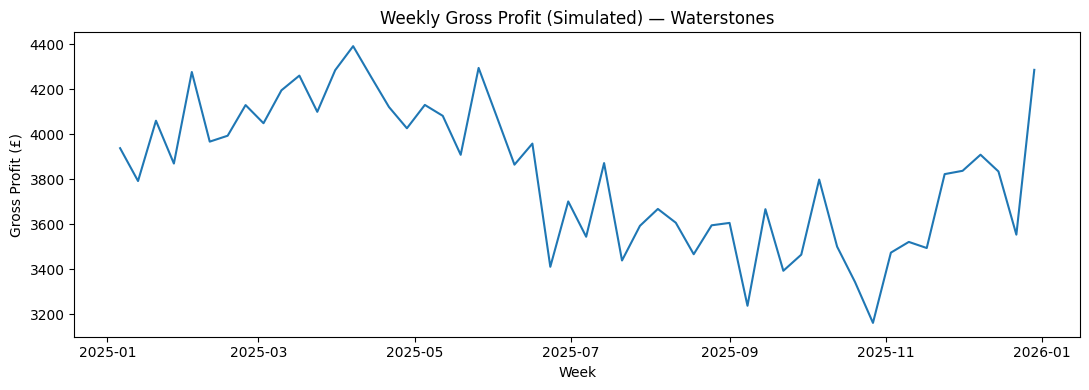

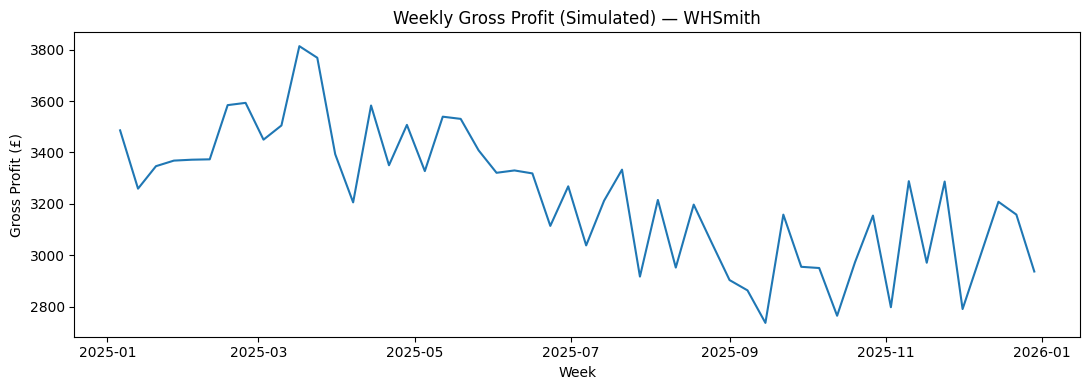

In [17]:
for chain in chains:
    subset = weekly_chain[weekly_chain["chain"] == chain]
    plt.figure(figsize=(11,4))
    plt.plot(subset["week"], subset["gross_profit"])
    plt.title(f"Weekly Gross Profit (Simulated) — {chain}")
    plt.xlabel("Week")
    plt.ylabel("Gross Profit (£)")
    plt.tight_layout()
    plt.show()


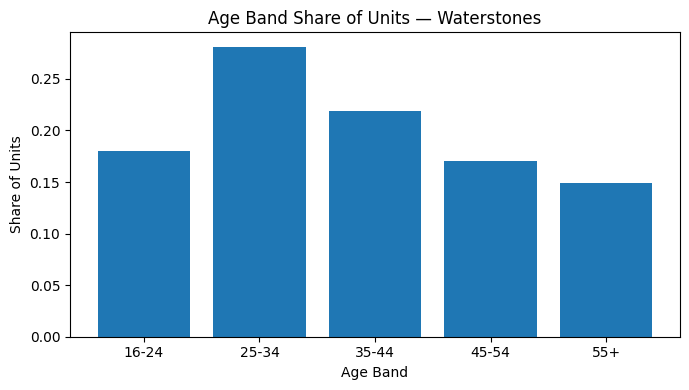

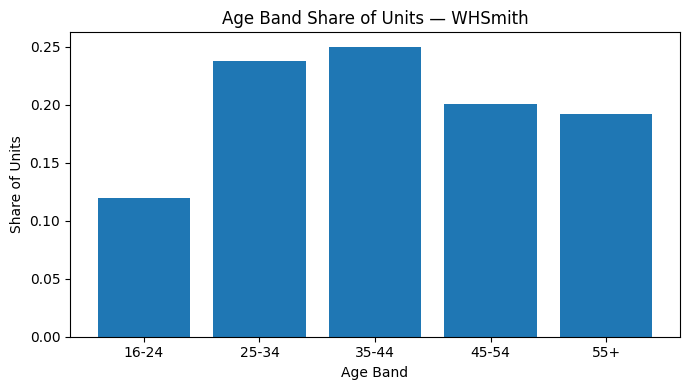

In [18]:
for chain in chains:
    subset = age_share[age_share["chain"] == chain].copy()
    subset = subset.sort_values("age_band")
    plt.figure(figsize=(7,4))
    plt.bar(subset["age_band"], subset["share"])
    plt.title(f"Age Band Share of Units — {chain}")
    plt.xlabel("Age Band")
    plt.ylabel("Share of Units")
    plt.tight_layout()
    plt.show()


In [19]:
sales.to_csv("joe_hill_england_sales_simulated.csv", index=False)
stores.to_csv("england_stores_simulated.csv", index=False)
weekly_chain.to_csv("weekly_chain_summary_simulated.csv", index=False)
yearly_chain.to_csv("yearly_chain_summary_simulated.csv", index=False)

print("Saved CSV files to the notebook working directory.")


Saved CSV files to the notebook working directory.
